In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-analogy/google_analogy_set.txt
/kaggle/input/simlex999/SimLex-999.txt
/kaggle/input/wordsim/combined.tab
/kaggle/input/news-dataset/hin_news_2022_300K-sentences.txt
/kaggle/input/news-dataset/eng_news_2024_300K-sentences.txt
/kaggle/input/glove-embedding/glove.6B.100d.txt


## Language Representations Part 1: Dense Representations

In [2]:
# importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Constructing the Co-Occurrence Matrix


In [3]:
# setting the path of the file
english_text_corpus_addr = '/kaggle/input/news-dataset/eng_news_2024_300K-sentences.txt'

# reading the text corpus
with open(english_text_corpus_addr, 'r') as file:
    english_text_corpus = file.readlines()

# printing the first 5 lines 
print(english_text_corpus[0:5])

['1\t$1,000 invested in Tesla 14 years ago is now…\n', '2\t$100 billion for the fourth straight year, reinsurers reported strong results for 2023 while cedents bore losses within higher retentions.\n', '3\t$1,105 at Hotels.\n', '4\t$12 off orders of $80 or more with code “AliExpress12OFF”\n', '5\t$13 million verdict secured against Burien cosmetic…\n']


In [4]:
# refining the text corpus
english_text_corpus_refined = []

for line in english_text_corpus:
    line = line.split('\t')[1] # splitting on tab character and taking the part after it
    line = line.strip() # removing the new line character
    english_text_corpus_refined.append(line)

# printing the first 5 lines
print(english_text_corpus_refined[0:5])

['$1,000 invested in Tesla 14 years ago is now…', '$100 billion for the fourth straight year, reinsurers reported strong results for 2023 while cedents bore losses within higher retentions.', '$1,105 at Hotels.', '$12 off orders of $80 or more with code “AliExpress12OFF”', '$13 million verdict secured against Burien cosmetic…']


In [5]:
# downloading nltk files for corpus processing (tokenizing, removing stopwords, lemmatization)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import os
import zipfile
import shutil

nltk.download('punkt', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')

print("Available Corpora:", os.listdir("/root/nltk_data/corpora"))

wordnet_zip_path = "/root/nltk_data/corpora/wordnet.zip"
extract_path = "/root/nltk_data/corpora"

# Delete any incorrectly extracted folder
shutil.rmtree(os.path.join(extract_path, "wordnet"), ignore_errors=True)

# Extract properly
with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extract directly into corpora folder

print("WordNet correctly extracted.")
print("WordNet files:", os.listdir("/root/nltk_data/corpora/wordnet"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Available Corpora: ['omw-1.4.zip', 'stopwords.zip', 'stopwords', 'wordnet.zip']
WordNet correctly extracted.
WordNet files: ['citation.bib', 'verb.exc', 'index.verb', 'data.adv', 'README', 'noun.exc', 'LICENSE', 'index.adj', 'index.sense', 'adv.exc', 'data.verb', 'index.noun', 'data.adj', 'index.adv', 'adj.exc', 'lexnames', 'cntlist.rev', 'data.noun']


In [6]:
# helper functions for tokenization, removing stopwords, removing punctuation and lemmatization
import re

stop_words = stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# function to get POS tag
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ  
    elif nltk_tag.startswith('V'):
        return wordnet.VERB  
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN  
    elif nltk_tag.startswith('R'):
        return wordnet.ADV  
    else:
        return wordnet.NOUN  

def remove_ordinals(text):
    # Pattern matches ordinal numbers like 1st, 2nd, 3rd, 4th, etc.
    ordinal_pattern = r'\b\d+(?:st|nd|rd|th)\b'
    cleaned_text = re.sub(ordinal_pattern, '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# function to remove punctuation and numbers, tokenize into words, lemmatize, remove stop words and returning a list of words
def process_line(line):

    line = line.lower() # changing to lowercase
    
    line = remove_ordinals(line)
    line = re.sub(r'[^a-zA-Z\s]', '', line) # removes punctuation and numbers
    
    words = word_tokenize(line) # tokenizing the line into words

    words = [word for word in words if word not in stop_words] # removing stop words
    
    pos_tags = pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tags)) for word, tags in pos_tags] # lemmatizing 

    return words


english_text_corpus_processed = []
for i, line in enumerate(english_text_corpus_refined):
    print(f"{i}/{len(english_text_corpus_refined)} lines processed.", end='\r')
    words = process_line(line)
    english_text_corpus_processed.append(words)

# printing the first 5 lines
print(english_text_corpus_processed[0:5])

[['invest', 'tesla', 'year', 'ago'], ['billion', 'fourth', 'straight', 'year', 'reinsurers', 'report', 'strong', 'result', 'cedents', 'bore', 'loss', 'within', 'high', 'retention'], ['hotel'], ['order', 'code', 'aliexpressoff'], ['million', 'verdict', 'secure', 'burien', 'cosmetic']]


In [7]:
#  function for co-occurrence matrix builder
from collections import Counter
from scipy.sparse import lil_matrix

def co_occurrence_matrix_builder(corpus, max_vocab_size=50000, window_size=2, sparse= False):
    
    all_words = [] # list of all words
    for words in corpus:
        for word in words:
            all_words.append(word)

    word_freq = Counter(all_words)
    most_common_words = set([word for word, _ in word_freq.most_common(max_vocab_size)]) # determining the most common words (max size is max_vocab_size), to address computational constraint
    vocab = list(most_common_words) # vocab
    word_to_idx = {word: idx for idx, word in enumerate(vocab)} # dictionary mapping

    vocab_size = len(vocab)

    if sparse:
        co_occurrence_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float32)
    else:
        co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)



    # building co-occurrence matrix
    for corpus_idx, words in enumerate(corpus):
        print(f"Building matrix using line {corpus_idx}/{len(corpus)}.", end= '\r')
        filtered_words = [word for word in words if word in word_to_idx] # filter sentence words based on the final vocab
        length_words = len(filtered_words)
        for i, word in enumerate(filtered_words):
            word_idx = word_to_idx[word]
            left_idx = max(0, i - window_size) # determing limit of left side of window
            right_idx = min(i + window_size, length_words - 1) # determining limit of right side of window
            for j in range(left_idx, right_idx + 1):
                if i != j:
                    neighbour_word = filtered_words[j]
                    neighbour_idx = word_to_idx[neighbour_word]
                    co_occurrence_matrix[word_idx, neighbour_idx] += 1
    print('\n')
    return co_occurrence_matrix, vocab, word_to_idx

Max number of words in a line in processed corpus is: 35
Min number of words in a line in processed corpus is: 0
Mean number of words in a line in processed corpus is: 11.047186666666667


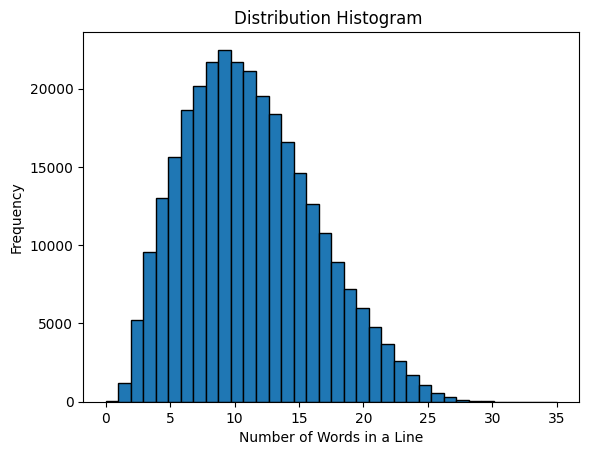

In [8]:
# printing some statistics about lengths of lines in processed corpus to determine window size
lengths_corpus_processed = [len(words) for words in english_text_corpus_processed]
print("Max number of words in a line in processed corpus is:", np.max(lengths_corpus_processed))
print("Min number of words in a line in processed corpus is:", np.min(lengths_corpus_processed))
print("Mean number of words in a line in processed corpus is:", np.mean(lengths_corpus_processed))
plt.hist(lengths_corpus_processed, bins=np.max(lengths_corpus_processed)+1, edgecolor='black')  
plt.xlabel('Number of Words in a Line')
plt.ylabel('Frequency')
plt.title('Distribution Histogram ')
plt.show()

In [9]:
# # building co-occurrence matrix for various window sizes
# window_sizes = [2, 4, 6, 8, 10]
# max_vocab_size = 50000
# for window_size in window_sizes:
#     print("Window Size:", window_size)
#     co_occurrence_matrix, _, _ = co_occurrence_matrix_builder(english_text_corpus_processed, max_vocab_size, window_size, sparse= True)
#     file_name = f"co_occurrence_matrix_{str(max_vocab_size)}_{str(window_size)}_sparse"
#     np.save(file_name, co_occurrence_matrix)
#     print('\n')

In [10]:
# we shall be using a dense matrix of NxN 
co_occurrence_matrix, vocab, word_to_idx = co_occurrence_matrix_builder(english_text_corpus_processed, max_vocab_size=50000, window_size=6, sparse= False)
print("Length of vocab:", len(vocab))
print("Shape of co-occurrence matrix:", np.shape(co_occurrence_matrix))

Building matrix using line 299999/300000.

Length of vocab: 50000
Shape of co-occurrence matrix: (50000, 50000)


### Reducing the dimensionality

In [11]:
# using PCA
from sklearn.decomposition import PCA

def reduce_pca(co_occurrence_matrix, lower_dimension):  
    pca = PCA(n_components=lower_dimension)
    reduced_pca_co_occurrence_matrix = pca.fit_transform(co_occurrence_matrix)
    return reduced_pca_co_occurrence_matrix

reduced_pca_co_occurrence_matrix = reduce_pca(co_occurrence_matrix, lower_dimension=100)
print(f"Original shape: {co_occurrence_matrix.shape}")
print(f"Reduced shape: {reduced_pca_co_occurrence_matrix.shape}")


Original shape: (50000, 50000)
Reduced shape: (50000, 100)


In [12]:
# using Random Projection
from sklearn.random_projection import GaussianRandomProjection

def reduce_rp(co_occurrence_matrix, lower_dimension):  
    transformer = GaussianRandomProjection(n_components= lower_dimension, random_state=42)
    # Fit and transform the co-occurrence matrix
    reduced_rp_co_occurrence_matrix = transformer.fit_transform(co_occurrence_matrix)
    return reduced_rp_co_occurrence_matrix

reduced_rp_co_occurrence_matrix = reduce_rp(co_occurrence_matrix, lower_dimension=100)
print(f"Original shape: {co_occurrence_matrix.shape}")
print(f"Reduced shape: {reduced_rp_co_occurrence_matrix.shape}")


Original shape: (50000, 50000)
Reduced shape: (50000, 100)


### Evaluating the Quality of Embeddings

In [13]:
# reading the simlex file
simlex_file_addr = '/kaggle/input/simlex999/SimLex-999.txt'

simlex_df = pd.read_csv(simlex_file_addr, sep='\t')

simlex_df.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


In [14]:
# scaling the simlex999 column using min-max scaling
simlex_df['SimLex999_scaled'] = (simlex_df['SimLex999'] - simlex_df['SimLex999'].min()) / (simlex_df['SimLex999'].max() - simlex_df['SimLex999'].min())
simlex_df.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),SimLex999_scaled
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41,0.141066
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67,0.937304
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19,0.892372
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18,0.973877
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93,0.075235


In [15]:
# reading the wordsimilarity file
wordsim_file_addr = '/kaggle/input/wordsim/combined.tab'

wordsim_df = pd.read_csv(wordsim_file_addr, sep='\t')

wordsim_df.head()

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [16]:
# scaling the word sim column using min max scaling
wordsim_df['wordsim_scaled'] = (wordsim_df['Human (mean)'] - wordsim_df['Human (mean)'].min()) / (wordsim_df['Human (mean)'].max() - wordsim_df['Human (mean)'].min())
wordsim_df.head()

,Word 1,Word 2,Human (mean),wordsim_scaled
0,love,sex,6.77,0.669396
1,tiger,cat,7.35,0.728762
2,tiger,tiger,10.00,1.000000
3,book,paper,7.46,0.740020
4,computer,keyboard,7.62,0.756397


In [17]:
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# function to evaluate the word pair similarity
def word_pair_similarity(word_embeddings, word_to_idx, simlex_df, wordsim_df, verbose = True):
    
    # doing for simlex
    cosine_similarities_scores = []
    simlex_scores = []
    for _, row in simlex_df.iterrows():
        word1, word2 = row['word1'], row['word2']
        if word1 in word_to_idx and word2 in word_to_idx:
            idx1, idx2 = word_to_idx[word1] , word_to_idx[word2]
            vec1, vec2 = word_embeddings[idx1], word_embeddings[idx2]
            cosine_sim = 1 - cosine(vec1, vec2)
            cosine_similarities_scores.append(cosine_sim)
            simlex_scores.append(row['SimLex999_scaled'])


    correlation_simlex, _ = spearmanr(cosine_similarities_scores, simlex_scores)
    mse_simlex = mean_squared_error(simlex_scores, cosine_similarities_scores)

    # doing for wordsim
    cosine_similarities_scores = []
    wordsim_scores = []
    for _, row in wordsim_df.iterrows():
        word1, word2 = row['Word 1'], row['Word 2']
        if word1 in word_to_idx and word2 in word_to_idx:
            idx1, idx2 = word_to_idx[word1] , word_to_idx[word2]
            vec1, vec2 = word_embeddings[idx1], word_embeddings[idx2]
            cosine_sim = 1 - cosine(vec1, vec2)
            cosine_similarities_scores.append(cosine_sim)
            wordsim_scores.append(row['wordsim_scaled'])

    correlation_wordsim, _ = spearmanr(cosine_similarities_scores, wordsim_scores)
    mse_wordsim = mean_squared_error(wordsim_scores, cosine_similarities_scores)

    if verbose:
        print(f"For Simlex-999: {len(simlex_scores)} samples")
        print("Correlation:", correlation_simlex)
        print("MSE:", mse_simlex)
        print('\n')
        print(f"For WordSim-353: {len(wordsim_scores)} samples ")
        print("Correlation:", correlation_wordsim)
        print("MSE:", mse_wordsim)

    return correlation_simlex,mse_simlex, correlation_wordsim,  mse_wordsim

In [18]:
# calling the function
print("For PCA embeddings:")
_,_, _, _ = word_pair_similarity(reduced_pca_co_occurrence_matrix, word_to_idx, simlex_df, wordsim_df)
print('-'*100)
print("For RP embeddings:")
_, _, _, _ = word_pair_similarity(reduced_rp_co_occurrence_matrix, word_to_idx, simlex_df, wordsim_df)

For PCA embeddings:
For Simlex-999: 990 samples
Correlation: 0.012470149763916057
MSE: 0.335461996923299


For WordSim-353: 324 samples 
Correlation: 0.17381629680326316
MSE: 0.2974883395042785
----------------------------------------------------------------------------------------------------
For RP embeddings:
For Simlex-999: 990 samples
Correlation: 0.02944524093616384
MSE: 0.1163631105141905


For WordSim-353: 324 samples 
Correlation: 0.1816318826383079
MSE: 0.09725643228827013


### Hyper Parameter study on Window Size, Reduction Dimension and Reduction Method

In [19]:
# function which runs the study

def hyper_param_study(english_text_corpus_processed, window_sizes, reduction_dimensions, reduction_methods,simlex_df, wordsim_df ):
    results = []
    for window_size in window_sizes:
        print(f"Window Size: {window_size}")
        co_occurrence_matrix, vocab, word_to_idx = co_occurrence_matrix_builder(english_text_corpus_processed, max_vocab_size=50000, window_size= window_size, sparse= False)

        for dimension in reduction_dimensions:
            print(f"Dimensions: {dimension}")
            for method in reduction_methods:
                print(f"Reduction method: {method}")
                if method == 'pca':
                    reduced_co_occurrence_matrix = reduce_pca(co_occurrence_matrix, lower_dimension=dimension)
                elif method == 'rp':
                    reduced_co_occurrence_matrix = reduce_rp(co_occurrence_matrix, lower_dimension=dimension)
                print(f"Evaluating.....")
                cs_sim, mse_sim, cs_ws, mse_ws = word_pair_similarity(reduced_co_occurrence_matrix, word_to_idx, simlex_df, wordsim_df, verbose=False)
    
                results.append({
                'window_size': window_size,
                'reduction_dimension': dimension,
                'reduction_method': method,
                'simlex_corr': cs_sim,
                'wordsim_corr': cs_ws,
                'simlex_mse': mse_sim,
                'wordsim_mse': mse_ws,
            })

    return results

In [20]:
# running the study
window_sizes = [2, 4, 6, 8, 10]
reduction_dimensions = [1, 50, 100, 150, 200, 250]
reduction_methods = ['pca', 'rp']

results = hyper_param_study(english_text_corpus_processed, window_sizes, reduction_dimensions, reduction_methods, simlex_df, wordsim_df)


Window Size: 2
Building matrix using line 299999/300000.

Dimensions: 1
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 50
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 100
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 150
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 200
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 250
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Window Size: 4
Building matrix using line 299999/300000.

Dimensions: 1
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 50
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 100
Reduction method: pca
Evaluating.....
Reduction method: rp
Evaluating.....
Dimensions: 150
Reduction method: pca
Evaluating.....
Reduction method:

In [21]:
results_df = pd.DataFrame(results)
results_df.to_csv('embedding_evaluation_results.csv', index=False)
print(results_df)

    window_size  reduction_dimension reduction_method  simlex_corr  \
0             2                    1              pca    -0.061381   
1             2                    1               rp     0.015290   
2             2                   50              pca     0.006718   
3             2                   50               rp     0.027674   
4             2                  100              pca     0.018622   
5             2                  100               rp     0.051253   
6             2                  150              pca     0.021549   
7             2                  150               rp     0.064752   
8             2                  200              pca     0.029674   
9             2                  200               rp     0.065279   
10            2                  250              pca     0.037663   
11            2                  250               rp     0.059744   
12            4                    1              pca    -0.043525   
13            4     

In [22]:
# finding the best features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
results_df[["simlex_corr_scaled", "wordsim_corr_scaled"]] = scaler.fit_transform(results_df[["simlex_corr", "wordsim_corr"]])

results_df["new_score"] = (results_df["simlex_corr_scaled"] + results_df["wordsim_corr_scaled"]) / 2
best_row = results_df.loc[results_df["new_score"].idxmax()]
best_params = list(best_row[["window_size", "reduction_dimension", "reduction_method"]])

print("Best Parameters:")
print(best_params)


Best Parameters:
[2, 250, 'rp']


In [23]:
# based on the hyper-parameter study,we find the best embeddings
def specific_embeddings(english_text_corpus_processed, window_size, reduction_dimension, reduction_method):
    co_occurrence_matrix, vocab, word_to_idx = co_occurrence_matrix_builder(english_text_corpus_processed, max_vocab_size=50000, window_size= window_size, sparse= False)
    if reduction_method == 'pca':
        reduced_co_occurrence_matrix = reduce_pca(co_occurrence_matrix, lower_dimension=reduction_dimension)
    elif reduction_method == 'rp':
        reduced_co_occurrence_matrix = reduce_rp(co_occurrence_matrix, lower_dimension=reduction_dimension)
    return reduced_co_occurrence_matrix, vocab, word_to_idx

window_size = best_params[0]
reduction_dimension = best_params[1]
method = best_params[2]

print(f"Best embeddings have window size {window_size}; reduced to dimension {reduction_dimension} using method {method}")
best_embeddings_matrix, vocab, word_to_idx = specific_embeddings(english_text_corpus_processed, window_size, reduction_dimension, method)

Best embeddings have window size 2; reduced to dimension 250 using method rp
Building matrix using line 299999/300000.



### Clustering and Visualization using t-SNE

In [24]:
from sklearn.cluster import KMeans
import random
def find_best_k(data, max_k=20, random_state=42):
    distortions = []
    K = range(1, max_k + 1)

    for k in K:
        print("Doing for:", k, end='\r')
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal K')
    plt.xticks(K)
    plt.grid(True)
    plt.show()

def cluster_embeddings(embeddings, vocab, num_clusters=20, random_state=42, top_n=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=10)
    kmeans.fit(embeddings)

    labels = kmeans.labels_

    # Print top_n words from each cluster
    for i in range(num_clusters):
        cluster_indices = np.where(labels == i)[0]
        
        centroid = kmeans.cluster_centers_[i]

        cluster_embeddings = embeddings[cluster_indices]
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

        sorted_indices = cluster_indices[np.argsort(distances)]

        print(f"\nCluster {i+1}:")
        print(", ".join([vocab[idx] for idx in sorted_indices[:top_n]]))


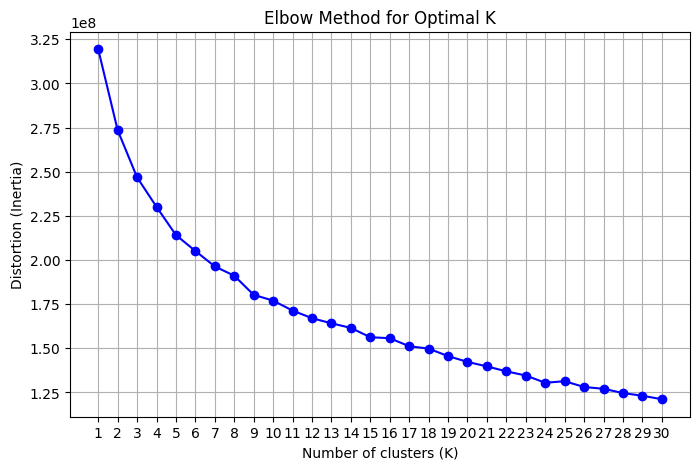

In [25]:
# for best_embeddings
find_best_k(best_embeddings_matrix, max_k = 30)

In [26]:
# for best_embeddings
best_k = 20
cluster_embeddings(best_embeddings_matrix, vocab, num_clusters=best_k, top_n=10)


Cluster 1:
sultana, caliendo, rosendahl, strapon, elokobi, taglines, chinau, maniyar, bradda, barletta

Cluster 2:
always, great, still, add, never, continue, try, plan, happen, didnt

Cluster 3:
buy

Cluster 4:
share

Cluster 5:
say

Cluster 6:
stock

Cluster 7:
see, think, want, come, know, work, would, go, also, look

Cluster 8:
stake, acquire, position, period, inc, sell, companys, purchase, llc, per

Cluster 9:
last

Cluster 10:
new

Cluster 11:
average, move, target

Cluster 12:
value, worth

Cluster 13:
year

Cluster 14:
time, one, day

Cluster 15:
fact, longer, conversation, agree, prepare, wouldnt, instead, although, fail, similar

Cluster 16:
rating

Cluster 17:
company

Cluster 18:
additional, quarter

Cluster 19:
four, five, later, past, six, earlier, since, old, end, three

Cluster 20:
own


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def plot_tsne_colored(embeddings, perplexity=30, learning_rate=200, random_state=42, clusters=10):
    indices = np.arange(embeddings.shape[0])

    kmeans = KMeans(n_clusters=clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=random_state)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plotting with color per cluster
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
                          c=cluster_labels, cmap='tab20', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title("t-SNE 2D Visualization of Word Embeddings (Cluster Colored)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

    return tsne_embeddings


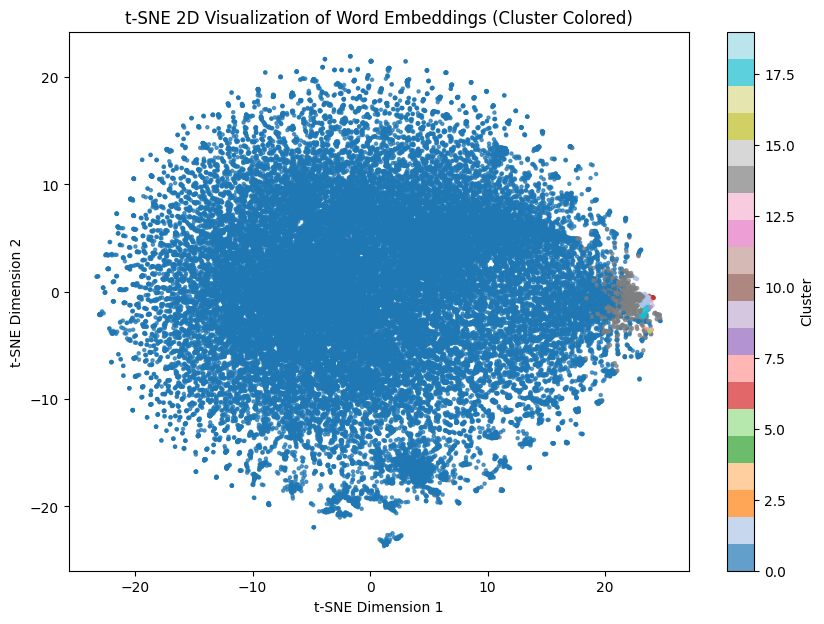

In [28]:
# t-SNE for best embeddings
_ = plot_tsne_colored(best_embeddings_matrix, perplexity=50, clusters=best_k)  


### Analogy tasks

In [29]:
google_analogy_test_addr = '/kaggle/input/google-analogy/google_analogy_set.txt'

with open(google_analogy_test_addr, 'r') as file:
    google_analogy_test = file.readlines()

google_analogy_test = google_analogy_test[1:] # removing the first line
print(google_analogy_test[0:5])

[': capital-common-countries\n', 'Athens Greece Baghdad Iraq\n', 'Athens Greece Bangkok Thailand\n', 'Athens Greece Beijing China\n', 'Athens Greece Berlin Germany\n']


In [30]:
google_analogy_cleaned_lines = []
categories_idx = []
for idx, line in enumerate(google_analogy_test):
    google_analogy_cleaned_lines.append(line.strip())
    if line[0] == ':': # to get category
        categories_idx.append(idx)
        print(line.strip())



: capital-common-countries
: capital-world
: currency
: city-in-state
: family
: gram1-adjective-to-adverb
: gram2-opposite
: gram3-comparative
: gram4-superlative
: gram5-present-participle
: gram6-nationality-adjective
: gram7-past-tense
: gram8-plural
: gram9-plural-verbs


In [31]:
#  to display examples of each category
for idx in categories_idx:
    print(f"{idx} : {google_analogy_cleaned_lines[idx:idx+5]}")

0 : [': capital-common-countries', 'Athens Greece Baghdad Iraq', 'Athens Greece Bangkok Thailand', 'Athens Greece Beijing China', 'Athens Greece Berlin Germany']
507 : [': capital-world', 'Abuja Nigeria Accra Ghana', 'Abuja Nigeria Algiers Algeria', 'Abuja Nigeria Amman Jordan', 'Abuja Nigeria Ankara Turkey']
5032 : [': currency', 'Algeria dinar Angola kwanza', 'Algeria dinar Argentina peso', 'Algeria dinar Armenia dram', 'Algeria dinar Brazil real']
5899 : [': city-in-state', 'Chicago Illinois Houston Texas', 'Chicago Illinois Philadelphia Pennsylvania', 'Chicago Illinois Phoenix Arizona', 'Chicago Illinois Dallas Texas']
8367 : [': family', 'boy girl brother sister', 'boy girl brothers sisters', 'boy girl dad mom', 'boy girl father mother']
8874 : [': gram1-adjective-to-adverb', 'amazing amazingly apparent apparently', 'amazing amazingly calm calmly', 'amazing amazingly cheerful cheerfully', 'amazing amazingly complete completely']
9867 : [': gram2-opposite', 'acceptable unacceptable

In [32]:
# making new dataset
start_idx = 8367
end_idx = 10680
google_analogy_refined_dataset = []
for i in range(start_idx, end_idx):
    line = google_analogy_cleaned_lines[i]
    if line[0] != ':' :
        google_analogy_refined_dataset.append(line)


print(google_analogy_refined_dataset[0:5])

['boy girl brother sister', 'boy girl brothers sisters', 'boy girl dad mom', 'boy girl father mother', 'boy girl grandfather grandmother']


In [33]:
# function for evaluating accuracy
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding_vector(embeddings, word_to_idx, word):
    return embeddings[word_to_idx[word]] if word in word_to_idx else None

def analogy_evaluation(embeddings, word_to_idx, line, top_k=1, verbose = False):
    vec_a = get_embedding_vector(embeddings, word_to_idx, line[0])
    vec_b = get_embedding_vector(embeddings, word_to_idx, line[1])
    vec_c = get_embedding_vector(embeddings, word_to_idx, line[2])
    vec_gt = get_embedding_vector(embeddings, word_to_idx, line[3])
    
    if vec_a is None or vec_b is None or vec_c is None or vec_gt is None:
        return -1 
        
    vec_pred = vec_a - vec_b + vec_c

    similarities = cosine_similarity(vec_pred.reshape(1, -1), embeddings)[0]

    top_indices = similarities.argsort()[-(top_k + 1):-1][::-1]  
    top_words = [word for word, idx in word_to_idx.items() if idx in top_indices]

    if verbose:
        print(line)
        print(top_words)

    return 1 if line[3] in top_words else 0  


In [34]:
correct = 0
top_k = 10
total_samples = 0
valid_indexes = []

for idx, line in enumerate(google_analogy_refined_dataset):
    print(f"Evaluating index {idx+1}/{len(google_analogy_refined_dataset)}", end='\r')
    value = analogy_evaluation(best_embeddings_matrix, word_to_idx, line, top_k)
    if value != -1:
        total_samples +=1
        correct += value
        valid_indexes.append(idx)

In [35]:
# accuracy
accuracy = correct/ total_samples
print("Total Correct:", correct)
print("Total Samples:", total_samples)
print("The accuracy is:", accuracy)

Total Correct: 22
Total Samples: 1615
The accuracy is: 0.013622291021671827


In [36]:
num_samples = 10
random_samples_idx = np.random.choice(range(0, len(valid_indexes)), num_samples, replace= False)
for idx in random_samples_idx:
    valid_idx = valid_indexes[idx]
    line = google_analogy_refined_dataset[valid_idx]
    _ = analogy_evaluation(best_embeddings_matrix, word_to_idx, line, top_k, verbose=True)

fortunate fortunately calm calmly
['accord', 'recent', 'disclosure', 'file', 'form', 'filing', 'exchange', 'sec', 'security', 'unaudited']
logical illogical impressive unimpressive
['write', 'riffle', 'l', 'also', 'bruce', 'moto', 'business', 'another', 'logitech', 'kishan']
typical typically occasional occasionally
['usd', 'n', 'kilo', 'respectively', 'litre', 'forint', 'placer', 'euro', 'aed', 'privatization']
complete completely efficient efficiently
['spokeswoman', 'mr', 'interview', 'delighted', 'official', 'spokesman', 'statement', 'prosecutor', 'goodbye', 'spokesperson']
precise precisely infrequent infrequently
['underused', 'landbank', 'kilo', 'litre', 'expectation', 'forint', 'kwh', 'placer', 'sarbanes', 'privatization']
groom bride stepbrother stepsister
['herbo', 'motorolas', 'satish', 'sinus', 'riffle', 'aspire', 'cosign', 'attacked', 'moto', 'nuisance']
complete completely quiet quietly
['spokeswoman', 'mr', 'interview', 'delighted', 'official', 'spokesman', 'statement', 

### Glove Embedding

In [37]:
glove_embedding_addr = '/kaggle/input/glove-embedding/glove.6B.100d.txt'

with open(glove_embedding_addr, 'r') as file:
    glove_embeddings =  file.readlines()

print(glove_embeddings[0:5])

['the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062\n', ', -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0

In [38]:
glove_embeddings_matrix = []
glove_vocab = []
glove_word_to_idx = {}
idx = 0
for i, line in enumerate(glove_embeddings):
    print(f"Checking line {i} / {(len(glove_embeddings))}", end='\r')
    line = line.strip()
    line = line.split(' ')
    if line[0] in vocab:
        glove_embeddings_matrix.append(list(map(float, line[1:])))
        glove_vocab.append(line[0])
        glove_word_to_idx[line[0]] = idx
        idx +=1

In [39]:
# converting glove embeddings
glove_embeddings_matrix = np.array(glove_embeddings_matrix)
print(glove_embeddings_matrix.shape)
print(glove_embeddings_matrix[0])

(43086, 100)
[ 0.085703 -0.22201   0.16569   0.13373   0.38239   0.35401   0.01287
  0.22461  -0.43817   0.50164  -0.35874  -0.34983   0.055156  0.69648
 -0.17958   0.067926  0.39101   0.16039  -0.26635  -0.21138   0.53698
  0.49379   0.9366    0.66902   0.21793  -0.46642   0.22383  -0.36204
 -0.17656   0.1748   -0.20367   0.13931   0.019832 -0.10413  -0.20244
  0.55003  -0.1546    0.98655  -0.26863  -0.2909   -0.32866  -0.34188
 -0.16943  -0.42001  -0.046727 -0.16327   0.70824  -0.74911  -0.091559
 -0.96178  -0.19747   0.10282   0.55221   1.3816   -0.65636  -3.2502
 -0.31556  -1.2055    1.7709    0.4026   -0.79827   1.1597   -0.33042
  0.31382   0.77386   0.22595   0.52471  -0.034053  0.32048   0.079948
  0.17752  -0.49426  -0.70045  -0.44569   0.17244   0.20278   0.023292
 -0.20677  -1.0158    0.18325   0.56752   0.31821  -0.65011   0.68277
 -0.86585  -0.059392 -0.29264  -0.55668  -0.34705  -0.32895   0.40215
 -0.12746  -0.20228   0.87368  -0.545     0.79205  -0.20695  -0.074273
  0.

In [40]:
# doing word pair similarity
_,_, _, _ = word_pair_similarity(glove_embeddings_matrix, glove_word_to_idx, simlex_df, wordsim_df)

For Simlex-999: 990 samples
Correlation: 0.29581875139375785
MSE: 0.08057198024047003


For WordSim-353: 324 samples 
Correlation: 0.5562611746965996
MSE: 0.04748545338380163


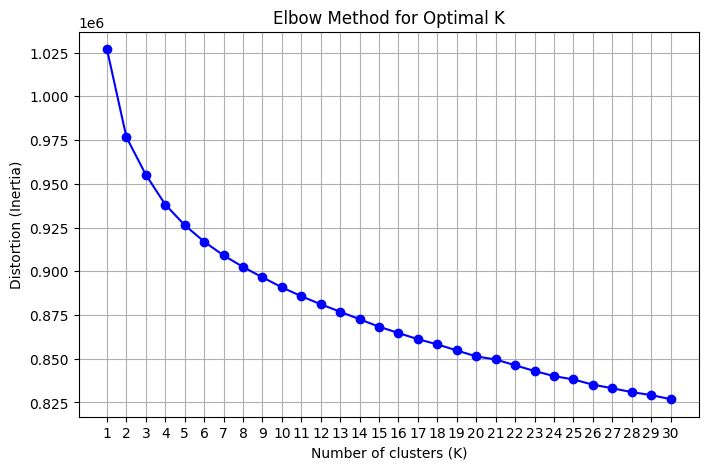

In [41]:
find_best_k(glove_embeddings_matrix, max_k = 30)

In [42]:
# for glove_embeddings
best_k = 20
cluster_embeddings(glove_embeddings_matrix, glove_vocab, num_clusters=best_k, top_n=10)


Cluster 1:
interestingly, vacuous, curiously, verbose, ponderous, ironically, predictably, delightfully, comically, undeniably

Cluster 2:
concoction, confection, preferably, yoghurt, chilis, sawdust, scoop, beeswax, croissant, curd

Cluster 3:
alienware, cofounder, acquires, vf, behemoth, trane, partnered, paragon, homeside, zenith

Cluster 4:
aforementioned, wherein, coincidentally, conjunction, describes, referencing, incorporating, inspiration, dubbed, explains

Cluster 5:
moreover, furthermore, likewise, consequently, meantime, importantly, additionally, whereby, hence, whereas

Cluster 6:
bodacious, bauble, minion, newbie, doppelganger, incidentally, boogeyman, schtick, monstrosity, imposter

Cluster 7:
dullness, nastiness, villainy, passivity, lastly, idiocy, clumsiness, conversely, weirdness, preoccupation

Cluster 8:
vicinity, underneath, riverbank, sprung, gigantic, beside, halfway, riverbed, stuck, stretched

Cluster 9:
whatsapp, selles, umaine, livs, sibiya, buchinger, lai

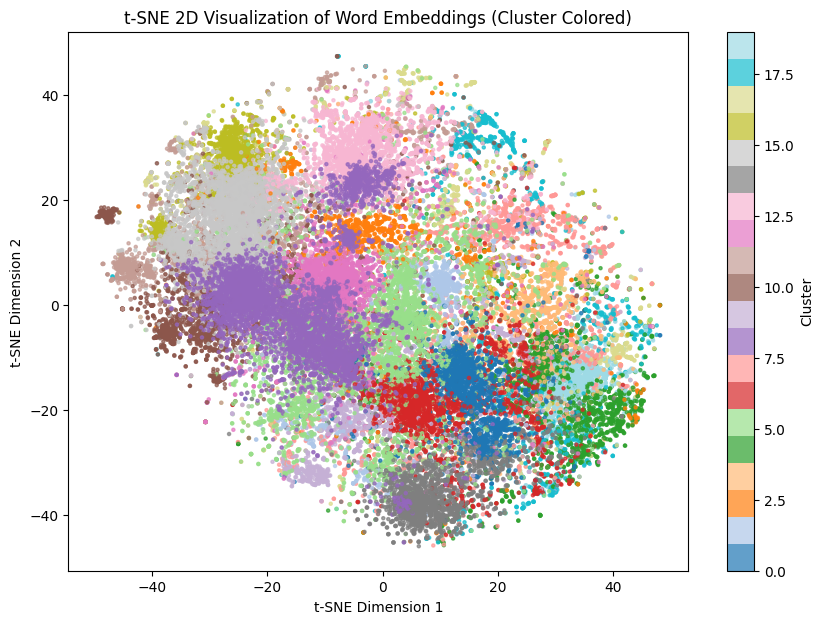

In [43]:
# t-SNE for glove embeddings
_ = plot_tsne_colored(glove_embeddings_matrix, perplexity=50, clusters=best_k)  

In [44]:
correct = 0
total_samples = 0
valid_indexes_glove = []

for idx, line in enumerate(google_analogy_refined_dataset):
    print(f"Evaluating index {idx+1}/{len(google_analogy_refined_dataset)}", end='\r')
    value = analogy_evaluation(glove_embeddings_matrix, glove_word_to_idx, line, top_k)
    if value != -1:
        total_samples +=1
        correct += value
        valid_indexes_glove.append(idx)

In [45]:
# accuracy
accuracy = correct/ total_samples
print("Total Correct:", correct)
print("Total Samples:", total_samples)
print("The accuracy is:", accuracy)

Total Correct: 249
Total Samples: 1615
The accuracy is: 0.15417956656346749


In [46]:
num_samples = 10
random_samples_idx = np.random.choice(range(0, len(valid_indexes_glove)), num_samples, replace= False)
for idx in random_samples_idx:
    valid_idx = valid_indexes_glove[idx]
    line = google_analogy_refined_dataset[valid_idx]
    _ = analogy_evaluation(glove_embeddings_matrix, glove_word_to_idx, line, top_k, verbose=True)

swift swiftly apparent apparently
['going', 'think', 'me', 'want', 'never', 'know', 'really', 'believe', 'thought', 'everyone']
professional professionally rare rarely
['s', 'p', 'n', 'f', 'k', 'h', 'te', 'si', 'yo', 'hermes']
reluctant reluctantly efficient efficiently
['c', 'd', 'g', 'n', 'f', 'k', 'l', 'w', 'h', 'coburn']
most mostly typical typically
['s', 'x', 'km', 'g', 'metres', 'height', 'sprint', 'meter', 'ft', 'metre']
infrequent infrequently quick quickly
['get', 'going', 'think', 'me', 'know', 'got', 'really', 'feel', 'sure', 'maybe']
lucky luckily calm calmly
['b', 'd', 'g', 'p', 'f', 'k', 'l', 'w', 'h', 'j']
known unknown possibly impossibly
['e', 's', 'b', 't', 'f', 'k', 'l', 'h', 'si', 'aa']
brother sister king queen
['s', 'b', 'c', 'en', 'h', 'j', 'se', 'te', 'si', 'bravo']
most mostly amazing amazingly
['s', 'x', 'km', 'g', 'metres', 'height', 'sprint', 'meter', 'ft', 'metre']
logical illogical likely unlikely
['x', 'd', 'm', 'f', 'k', 'l', 'w', 'h', 'mg', 'gs']
